# The Molecular Fragment Approach: Anthracene Dimer

In this tutorial you will learn how to use the molecular fragment approach of BigDFT, which generates optimised support functions for an isolated molecular template, and then uses them as a fixed basis for a larger system. In this tutorial, we consider the case of an anthrancene dimer. The anthracene molecules are kept rigid, and thus we do not need to pay attention to any internal molecular distortions.

This tutorial follows the methodology described in L. E. Ratcliff, L. Genovese, S. Mohr and T. Deutsch, J. Chem. Phys. 142, 234105 (2015) and L. E. Ratcliff, L. Grisanti, L. Genovese, T. Deutsch, T. Neumann, D. Danilov, W. Wenzel, D. Beljonne and J. Cornil, J. Chem. Theory Comput. 11, 2077 (2015).

This tutorial assumes that you are familiar with the basics of PyBigDFT and BigDFT, including the system class, linear scaling BigDFT, and running calculations.

Notebook by Dr. Laura Ratcliff. 

## Anthracene Dimer

### Template Calculation

We are going to consider an anthracene dimer, with various orientations, however the approach can easily be generalised to a system containing many more molecules. Let's take a look at a single molecule of anthracene, which will form our template:

In [ ]:
install = "client (Google drive)" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

In [3]:
install.data('data/anthracene_dimer.tar.gz')

In [4]:
from BigDFT.Visualization import InlineVisualizer
from BigDFT.Systems import System
from BigDFT.IO import read_xyz

# first we read in the molecule
template_name = 'monomer'
ifile = open(template_name+'.xyz')
template = read_xyz(ifile, fragmentation='single')
ifile.close()

# then we can visualise it
template.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

First we setup the linear scaling input file for the template molecule. At the same time, we also create an input file for the fragment calculation, so we can set some common parameters.

In [5]:
from BigDFT import Inputfiles as I, InputActions as A

# template input file
inpt = I.Inputfile()

# fragment input file
inpf = I.Inputfile()

# common parameters
for inp in [inpt, inpf]:
    # set the grid spacing, XC functional and specify pseudopotential type
    inp.set_hgrid(0.5)
    inp.set_xc('PBE')
    inp.set_psp_nlcc()
    
    # import the linear scaling profile
    inp['import'] = 'linear'
    
    # turn off the communications checks, which can be costly for larger systems
    inp.update({'perf': {'check_sumrho': 0, 'check_overlap': 0}})
    
    # output the SFs in binary format, and skip the multipole calculation
    inp.update({'lin_general': {'output_wf': 2, 'charge_multipoles': 0}})

Now we set up the system calculator. Here we are using 16 MPI tasks and 2 OpenMP threads, due to the size of the machine. However, this can easily be adjusted for your own setup. 

It is also possible to set the ```BIGDFT_MPIRUN``` and ```OMP_NUM_THREADS``` environment variables before launching the notebook, in which case there is no need to set the values agin in the system calculator.

In [6]:
from BigDFT import Calculators as C
code = C.SystemCalculator(omp=2, mpi_run='mpirun -n 16', verbose=False, skip=True)

Let's also define some functions to check convergence in both the full linear scaling and fixed support function calculations.

In [7]:
def check_convergence_optimised_sfs(run):
    
    # in this case we check the convergence of the outer loop
    dout = run.log['Ground State Optimization'][-1]['self consistency summary'][-1]['delta out']

    # check what threshold we were trying to meet
    dthresh = float(run.log['lin_general']['rpnrm_cv'])
    
    if dout > dthresh:
        print('WARNING, calculation did not converge')
        return False
    else:
        return True
    
def check_convergence_fixed_sfs(run):
    
    # in this case we check the convergence of the kernel loop
    dout = run.log['Ground State Optimization'][-1]['kernel optimization'][-1]['summary']['delta']

    # check what threshold we were trying to meet
    dthresh = float(run.log['lin_kernel']['rpnrm_cv'])
    
    if dout > dthresh:
        print('WARNING, calculation did not converge')
        return False
    else:
        return True

Now we are ready to run the template calculation.

In [8]:
run_template = code.run(input=inpt, sys=template, name=template_name)                

# check if the calculation converged
converged = check_convergence_optimised_sfs(run_template)

Ha2eV = 27.211396132
template_energy = Ha2eV * run_template.energy / run_template.nat
template_time = run_template.log['Timings for root process']['Elapsed time (s)'] / 60.0   
                    
print('Anthracene template took '+'{0:.1f}'.format(template_time)+' minutes, E = '+\
      '{0:.3f}'.format(template_energy)+' eV/atom')

Anthracene template took 1.4 minutes, E = -111.059 eV/atom


### Dimer Calculation - Full Linear Scaling

Now we have finished the template calculation, let's calculate the dimer energies using the full linear scaling approach, using a similar input file. This will give us a reference to which we can compare the fragment approach. First let's visualise an example dimer.

In [10]:
dimer_name = 'dimer_4_0_0_0'
ifile = open(dimer_name+'.xyz')
# as above, we read the system in as a single fragment.
# we could define the fragments correctly, but for this tutorial we don't need to do so
dimer = read_xyz(ifile, fragmentation='single')
ifile.close()

dimer.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's run the dimer.

In [11]:
# we will give the run a different name from the xyz file,
# in order to distinguish it from the fragment calculation we will do on the same system
name = dimer_name+'_linear'

# we also don't need to print the matrices or support functions, so we can turn that off
inpt['lin_general'].update({'output_wf': 0, 'output_mat': 0})

# however, we do want to calculate the KS energies using a one-off diagonalisation
# this is activated by default when the support functions are written to disk, so we will turn it on explicitly
inpt['lin_general'].update({'subspace_diag': True})

run_full = code.run(input=inpt, sys=dimer, name=name)    

# check if the calculation converged
converged = check_convergence_optimised_sfs(run_full)

full_energy = Ha2eV * run_full.energy / run_full.nat
full_time = run_full.log['Timings for root process']['Elapsed time (s)'] / 60.0   
                    
print('Fully optimised anthracene dimer took '+'{0:.1f}'.format(full_time)+' minutes, E = '+\
      '{0:.3f}'.format(full_energy)+' eV/atom')

Fully optimised anthracene dimer took 2.9 minutes, E = -111.058 eV/atom


### Single Dimer Calculation - Fragment Approach

Let's now set up the fragment calculation for the same dimer - first we need to do some directory manipulation. 

The folder in which we are running the calculations must both the position file, e.g. ```dimer.xyz```, and an associated BigDFT data directory, ```data-dimer```. The equivalent files for the template must be contained inside the dimer data directory, i.e. ```data-dimer``` should contain ```monomer.xyz``` and ```data-monomer```.

We will use symbolic links to achieve this by linkinh to the already generated template files.

In [12]:
# first identify the current working directory
import os
main_dir = os.getcwd()

# make a data directory for our fragment calculation
# define the name which will be given to the calculation
fragment_name = dimer_name+'_fragment'
data_dir = 'data-'+fragment_name
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# now let's enter the data directory
os.chdir(data_dir)

# in here we need both the atomic structure of the template molecule...
if not os.path.islink(template_name+'.xyz'):
    os.symlink('../'+template_name+'.xyz', template_name+'.xyz')

# and the data directory associated with the template
if not os.path.islink('data-'+template_name):
    os.symlink('../data-'+template_name, 'data-'+template_name)

# since we now have everything we need, we can go back to the main directory    
os.chdir(main_dir)

Now we can set up the fragment input file - the basic parameters are the same as the full calculation, but we need to make some adjustments.

In [13]:
# we want to restart from the existing SFs and matrices
inpf['dft'].update({'inputpsiid': 'linear_restart'})

# we don't want any of the kernel convergence thresholds to be automatically modified
inpf['perf'].update({'adjust_kernel_iterations': False, 'adjust_kernel_threshold': False})

# we also turn off hybrid mode, I/O etc, and change the outer loop iterations to 1
inpf['lin_general'].update({'hybrid': False, 'nit': [0, 1], 'output_mat': 0, 'output_wf': 0,
                            'subspace_diag': True})

# we dont't want to further optimise the SF basis
inpf.update({'lin_basis': {'nit': 1, 'idsx': 1}})

# and we need to increase the number of kernel iterations, to ensure it fully converges
inpf.update({'lin_kernel': {'nit': 200, 'rpnrm_cv': 1.0e-11, 'delta_pnrm': -1, 'alphamix': 0.1}})

# finally, we need to setup the list of fragments, for which we need to know how many fragments the system has
# we could manually set it to 2, but the code below is more easily generalisable, to e.g. a trimer
# since all fragments are identical so we can simply use the number of atoms
nat_dimer = len([at for at in dimer.get_atoms()])
nat_template = len([at for at in template.get_atoms()])
nfrag = int(nat_dimer / nat_template)

# all fragments have the same template, so we can simply make a list of fragment indices 
# and associate it with that template
# this tells BigDFT which atoms in the full system are associated with which template instance
inpf.update({'frag': {template_name: [i for i in range(1, nfrag + 1)]}})

Now we have everything we need to run the fragment calculation.

In [14]:
name = dimer_name+'_fragment'

# we need to remember to use the fragment input file, instead of the template one
run_fragment = code.run(input=inpf, sys=dimer, name=name)    

converged = check_convergence_fixed_sfs(run_fragment)

fragment_energy = Ha2eV * run_fragment.energy / run_fragment.nat
fragment_time = run_fragment.log['Timings for root process']['Elapsed time (s)'] / 60.0   
                    
print('Fragment calculation for the anthracene dimer took '+'{0:.1f}'.format(fragment_time)+' minutes, E = '+\
      '{0:.3f}'.format(fragment_energy)+' eV/atom')

Fragment calculation for the anthracene dimer took 0.7 minutes, E = -111.056 eV/atom


### Results

Now that we've finished the calculations, let's make a table summarising the results, where we show:
- the total energy
- the interaction energy, defined as $E_{interaction} = E_{dimer} - 2 E_{monomer}$
- the error relative to the full linear scaling result
- the total time taken, which in the fragment case includes the cost of the template calculation

The error resulting from using the fragment approach is very small - around 2 meV/atom. This is because we are in a good regime for the fragment approach, with rigid templates and relatively weakly interacting fragments, as evidenced by the relatively low interaction energy.

In [15]:
import pandas as pd
from IPython.display import display

rows = ['Linear Scaling', 'Fragment']
columns = ['Total Energy (eV)', 'Interaction Energy (eV)', 'Error (meV/atom)', 'Total Time (s)']

table_data = [[full_energy * run_full.nat, 
               full_energy * run_full.nat - nfrag * template_energy * run_template.nat,
               0.0, 
               60.0 * full_time],
              [fragment_energy * run_fragment.nat, 
               fragment_energy * run_fragment.nat - nfrag * template_energy * run_template.nat,
               1000.0 * (fragment_energy - full_energy),
               60.0 * (template_time + fragment_time)]]

table = pd.DataFrame(table_data, index=rows, columns=columns)

table.round(4)

,Total Energy (eV),Interaction Energy (eV),Error (meV/atom),Total Time (s)
Linear Scaling,-5330.7668,0.0778,0.0000,173.52
Fragment,-5330.6870,0.1576,1.6626,125.76


## Rotating Dimer

Now we know we how to run the dimer calculation, we can try varying the orientation between the molecules. First let's define our list of pre-rotated input structures, where one of the molecules has been rotated by a range of angles between 0 and 90$^\circ$, in intervals of 15$^\circ$.

In [16]:
# the structures are named with the separation distance, and angle of rotation for each axis
angles = range(0, 105, 15)
dimer_names = ['dimer_4_0_'+str(i)+'_0' for i in angles]
print(dimer_names)

['dimer_4_0_0_0', 'dimer_4_0_15_0', 'dimer_4_0_30_0', 'dimer_4_0_45_0', 'dimer_4_0_60_0', 'dimer_4_0_75_0', 'dimer_4_0_90_0']


### Linear Scaling Calculations

We can use the same input file to run the linear scaling calculations. Since we have set ```skip=True``` in the calculator, the 0$^\circ$ structure will not be rerun by BigDFT.

In [17]:
linear_dimer_runs = []
for dimer_name in dimer_names:  
    
    name = dimer_name+'_linear'

    # we're not going to display the dimer, so we can run BigDFT directly using the .xyz file
    # rather than passing a system
    run = code.run(input=inpt, posinp=dimer_name+'.xyz', name=name)    
    
    # let's save the runs in a list, for post-processing later
    linear_dimer_runs.append(run)

    converged = check_convergence_optimised_sfs(run)

    # since we will post-process later, let's just print a message to confirm the calculation has finished
    print('Calculation for',dimer_name,'complete')

Calculation for dimer_4_0_0_0 complete
Calculation for dimer_4_0_15_0 complete
Calculation for dimer_4_0_30_0 complete
Calculation for dimer_4_0_45_0 complete
Calculation for dimer_4_0_60_0 complete
Calculation for dimer_4_0_75_0 complete
Calculation for dimer_4_0_90_0 complete


### Fragment Calculations

We can use the same template as before, so there is no need to rerun. We could follow the same process as before to link directories. However, we can also just use the existing dimer directory by changing the radical of the calculation. Since we are not writing out any matrices or support functions, we will not overwrite any of the directory's contents, so this is safe to do.

In [18]:
fragment_dimer_runs = []
for dimer_name in dimer_names:
    
    name = dimer_name+'_fragment'
    
    # update the radical to match the first dimer structure considered
    inpf.update({'radical': dimer_names[0]+'_fragment'})

    run = code.run(input=inpf, posinp=dimer_name+'.xyz', name=name)  
    
    fragment_dimer_runs.append(run)

    converged = check_convergence_fixed_sfs(run)

    print('Calculation for',dimer_name,'complete')

Calculation for dimer_4_0_0_0 complete
Calculation for dimer_4_0_15_0 complete
Calculation for dimer_4_0_30_0 complete
Calculation for dimer_4_0_45_0 complete
Calculation for dimer_4_0_60_0 complete
Calculation for dimer_4_0_75_0 complete
Calculation for dimer_4_0_90_0 complete


### Results

Now let's visualise the results.

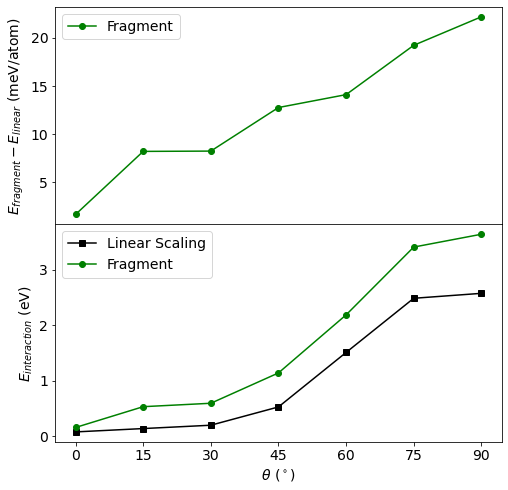

In [19]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

fig.subplots_adjust(hspace=0.0)

# first plot the interaction energy
ax = axs[1]
ax.plot(angles,
        [Ha2eV * run.energy - 2 * template_energy * run_template.nat for run in linear_dimer_runs],
        color='black', marker='s', label='Linear Scaling')

ax.plot(angles,
        [Ha2eV * run.energy - 2 * template_energy * run_template.nat for run in fragment_dimer_runs],
        color='green', marker='o', label='Fragment')

ax.set_ylabel('$E_{interaction}$ (eV)')
ax.set_xlabel('$\\theta$ ($^\circ$)')

# now plot the error coming from the fragment approach
ax = axs[0]

ax.plot(angles,
        [1000.0 * (Ha2eV * run.energy/run.nat - Ha2eV * linear_dimer_runs[i].energy/linear_dimer_runs[i].nat)
         for i,run in enumerate(fragment_dimer_runs)],
         color='green', marker='o', label='Fragment')

ax.set_ylabel('$E_{fragment} - E_{linear}$ (meV/atom)')

for i in range(2):
    ax = axs[i]
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.legend(loc='upper left')

plt.show()

While the fragment approach overall follows the trend of the linear scaling results, the error is larger for the larger angles. We can understand this a bit better by looking at the structure for the system which is rotated by 90$^\circ$.

In [20]:
dimer_name = 'dimer_4_0_90_0'
ifile = open(dimer_name+'.xyz')
dimer90 = read_xyz(ifile, fragmentation='single')
ifile.close()

viz = InlineVisualizer(400, 400)
viz.display_system(dimer90, zoom=1.0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Unlike the unrotated dimer, we can see that the minimum separation distance between atoms of each of molecule is much smaller, so that the molecules are much more strongly interacting. Indeed, this is what we could already see in the graph of the interaction energy. In other words, the more strongly interacting the fragments, the larger the error induced by using the fragment approach. This error will of course depend on both the system, and the _quantity of interest_. To illustrate this point, let's also try looking at the density of states (DoS).

In [21]:
# Gaussian smearing width
sigma = 0.3
# energy range over which to generate the DoS
e_min = -35.0
e_max = 10.0
# energy resolution of the DoS
de = 0.05

# BigDFT has its own plotting routines for the DoS
# however here we define our own function to access quantities in a way which can easily be manipulated
def extract_dos(run):
    dos_log = run.get_dos(sigma=sigma, deltae=de, e_min=e_min, e_max=e_max)
    curves = dos_log.get_curves()
    energies = curves['1'][0]
    spectrum = curves['1'][1]
    return {'dos': dos_log, 'energies': energies, 'spectrum': spectrum}

# extract the DoS for select runs
template_dos = extract_dos(run_template)
linear_dos = []
for run in linear_dimer_runs:
    linear_dos.append(extract_dos(run))
fragment_dos = []
for run in fragment_dimer_runs:
    fragment_dos.append(extract_dos(run))

Having extracted the DoS, now we can plot the comparison.

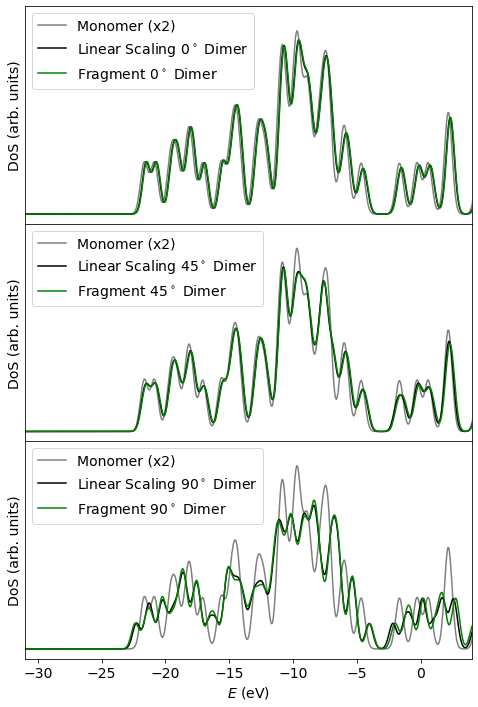

In [22]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

fig.subplots_adjust(hspace=0.0)

# plot comparison for 0, 45 and 90 degrees
inds = [0, 3, -1]
degs = [0, 45, 90]

for i in range(3):
    ax = axs[i]
    ind = inds[i]
    
    ax.plot(template_dos['energies'], [2.0 * td for td in template_dos['spectrum']],
            color='grey', label='Monomer (x2)')
    ax.plot(linear_dos[ind]['energies'], linear_dos[ind]['spectrum'],
            color='black', label='Linear Scaling '+str(degs[i])+'$^\circ$ Dimer')
    ax.plot(fragment_dos[ind]['energies'], fragment_dos[ind]['spectrum'],
            color='green', label='Fragment $'+str(degs[i])+'^\circ$ Dimer')

    ax.set_xlabel('$E$ (eV)')
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel('DoS (arb. units)')
    ax.legend(loc='upper left')
    ax.set_xlim([-31, 4])

plt.show()

As expected, the differences between the linear scaling and fragment-calculated DoS are more noticeable for the larger angles. However, even in the 90$^\circ$ case, these discrepancies are much smaller than the difference between the sum of the monomer DoS. In other words, the interactions are still reasonably well captured, even in the most strongly interacting case. 

We can also quantify these differences in the DoS by taking the average absolute difference between the linear scaling and fragment DoS for each timer. As expected, the larger angles show larger differences in the DoS, although unlike the total energy, this is not monotonic. As with the error in total energy, whether or not such differences are significant will depend on the particular application.

In [23]:
for l in range(len(angles)):
    ldos = linear_dos[l]
    fdos = fragment_dos[l]
    diff = sum(abs(ldos['spectrum'][i] - fdos['spectrum'][i]) for i in range(len(ldos['spectrum'])))
    diff /= len(ldos['spectrum'])
    print('Average difference for dimer rotated by '+'{0:.0f}'.format(angles[l])+\
          ' degrees = '+'{0:.2f}'.format(diff))

Average difference for dimer rotated by 0 degrees = 0.08
Average difference for dimer rotated by 15 degrees = 0.08
Average difference for dimer rotated by 30 degrees = 0.08
Average difference for dimer rotated by 45 degrees = 0.10
Average difference for dimer rotated by 60 degrees = 0.09
Average difference for dimer rotated by 75 degrees = 0.12
Average difference for dimer rotated by 90 degrees = 0.15


## Exercise

Now you know how to run fragment calculations, you can combine this knowledge with the tools PyBigDFT has for building systems. In other words, you can use the System and Fragment classes to build your own systems which can then be calculated using the fragment approach. 

- Build a set of dimers without rotation (i.e. 0$^\circ$), but varying the separation distance along the _x_ axis from 2.5 to 12 $\\A$ in increments of 0.5 $\\A$, (so far this has been fixed at 4 $\\A$). 

You may wish to consider the following hints:

- You can use the fragment "translate" function from the system generation tutorial to shift the template monomer, but don't forget to convert the shift from angstroms to atomic units, which is what PyBigDFT uses internally.

- At the beginning of the notebook, we defined template as a "system" containing a single "fragment" (the monomer), which you can use to build the dimer.

- You will need to manipulate the fragment (rather than the system) - when a name isn't specified, the first fragment will be by default named "FRA:0". In other words, you can use template["FRA:0"] as a starting point.

- You may also make use of deepcopy, to avoid modifying the original monomer.

- In the process, you should save both a list of systems (e.g. new_dimers), and a list of dimer names (new_dimer_names).

- Don't forget to import the relevant modules and routines (e.g. Fragments, write_xyz).

- Use the visualizer to check your structures look sensible - it is not necessary to look at them all, you could for example only look at the first system in your list.

- Write the structures to file using the same naming convention as before, i.e. dimer_d_0_0_0.xyz, where _d_ is the distance. 
- You can use the write_xyz function of BigDFT.IO, which takes the arguments (system, ofile), but which can otherwise be used in the same way as read_xyz (i.e. you will need to open a file, write to xyz, and close the file, similarly to cell 1).

- The structures have been pre-prepared and written to file, using the name ref_d.xyz, where _d_ is the distance. Check that your files are correct using the diff command below - you may wish to add a loop over distance.

In [ ]:
!diff dimer_4_0_0_0.xyz ref_4.xyz

- Run full linear scaling and fragment calculations using the same inputs as above. Hint: you can copy cells 13 and 14 above to run the calculations, but looping over new_dimer_names instead of dimer_names for the loop. Note that we still need to know the name of the data directory to use for the fragments.

- Plot the results using the same format as cell 15. How does the error in energy vary with distance? 

You may have noticed that the error at longer distances doesn't tail off to zero, but is instead roughly cyclical, albeit small (around 6 meV/atom or less). This is due to the eggbox effect which comes from interpolating the support functions as they are shifted relative to the grid. It could be reduced either by using a smaller grid spacing, or using a grid spacing which is commensurate with the shift, so that no interpolation is required.